# Desenvolvimento de rede neural artifical para predição de defeitos em motor redutor

> #### Equipe: 
> Raul Bernardo de Pontes Pires;
> 
> Wellyosn Carlos Pontes da Silva.
> 

O objetivo central deste projeto é criar uma rede neural dedicada à previsão de falhas em motores por meio da análise de áudio. Inicialmente, realizamos a coleta de áudios do motor em pleno funcionamento e em perfeitas condições. Posteriormente, o motor foi submetido a uma série de problemas, e os áudios foram coletados novamente.

Com a base de áudios em mãos, iniciamos o processo de desenvolvimento da rede neural. O primeiro passo é a padronização dos dados, seguindo o seguinte fluxo:

1. Aplicação da Transformada Rápida de Fourier (FFT) em cada áudio.
2. Correlação dos 5 maiores picos da FFT de cada áudio.
3. Armazenamento desses dados em uma tabela CSV.

Para facilitar esse processo, foi desenvolvido um sistema que percorre a pasta _`audios`_. Essa pasta contém subpastas correspondentes a cada tipo de defeito ao qual o motor foi submetido. O sistema entra em cada subpasta, aplica o fluxo mencionado anteriormente e preenche a tabela CSV com as informações relevantes.



## Aquisição dos dados

* Instalando algumas das bibliotecas que serão utilizadas no projeto.

In [10]:
import os
import numpy as np
import librosa as lib
import csv
import pandas as pd
from scipy.stats import kurtosis

- Vamos criar uma variável chamada _`pasta_principal`_ que armazenará a String relativa ao local onde os audios serão depositados;
- Vamos criar também uma variável (_`resultados_por_audio`_) que será responsavél de armazenar os dados relativos a criação da tabela CSV.

In [11]:
pasta_principal = "audios"

resultados_por_audio = []

Aqui está o código em que percorremos todas as subpastas da pasta _`audios`_, entrando em cada uma e iterando sobre todos os áudios presentes. Durante esse processo, a variável _`resultados_por_audio`_ é preenchida com informações relevantes:

- **Objetivo:** Armazenar os 5 maiores valores (frequência e amplitude) da FFT de cada áudio.
- **Inclusões na variável _`resultados_por_audio`_:**
  - Nome do arquivo.
  - Tipo de defeito (correspondente ao nome da subpasta).
  - Valores de desvio padrão, Kurtosis e RMS.



In [12]:
for subpasta in os.listdir(pasta_principal):
    caminho_subpasta = os.path.join(pasta_principal, subpasta)

    if os.path.isdir(caminho_subpasta):
        arquivos_audios = [f for f in os.listdir(caminho_subpasta) if f.endswith(".wav")]

        for arquivo_audio in arquivos_audios:
            caminho_audio = os.path.join(caminho_subpasta, arquivo_audio)
            sinal, fs = lib.load(caminho_audio)
            sinal = sinal[:5 * fs]
            n = len(sinal)
            janela = np.hamming(n)
            sinal_janelado = janela * sinal
            Y = np.abs(np.fft.fft(sinal_janelado)) / n
            frequencias = np.linspace(0, fs / 2, n // 2)  
            
            std_dev = np.std(sinal) 
            kurt = kurtosis(sinal) 
            rms = np.sqrt(np.mean(sinal**2))  

            frequencias = frequencias[:n // 2]
            amplitudes = Y[:n // 2]

            indices_maiores = np.argsort(amplitudes)[::-1][:5]

            resultados_por_audio.append({
                "Defeito": subpasta,
                "DesvioPadrão": std_dev,
                "Kurtosis": kurt,
                "rms": rms,
                "CincoMaioresPontos": [(frequencias[i], amplitudes[i]) for i in indices_maiores]
            })

De posse da variável _`resultados_por_audio`_ já povoada, podemos então criar a tabela CSV.

In [13]:
with open('resultados.csv', 'w', newline='') as csvfile:
    colunas = ["defeito", "desvio_padrao", "kurtosis", "rms", "frequencia_1", "amplitude_1", "frequencia_2", "amplitude_2", "frequencia_3", "amplitude_3", "frequencia_4", "amplitude_4", "frequencia_5", "amplitude_5"]
    csv_writer = csv.DictWriter(csvfile, fieldnames=colunas)
    csv_writer.writeheader()

    for resultado in resultados_por_audio:
        linha = {"defeito": resultado["Defeito"], "desvio_padrao": resultado["DesvioPadrão"], "kurtosis": resultado["Kurtosis"], "rms": resultado["rms"] }
        for i, ponto in enumerate(resultado["CincoMaioresPontos"], start=1):
            linha[f"frequencia_{i}"] = ponto[0]
            linha[f"amplitude_{i}"] = ponto[1]
        csv_writer.writerow(linha)

print("Resultados foram escritos no arquivo CSV: resultados.csv")

Resultados foram escritos no arquivo CSV: resultados.csv


Por fim, podemos plotar os 10 primeiros items da tabela.

In [14]:
resultados = pd.read_csv("resultados.csv")
resultados.head(10)


,defeito,desvio_padrao,kurtosis,rms,frequencia_1,amplitude_1,frequencia_2,amplitude_2,frequencia_3,amplitude_3,frequencia_4,amplitude_4,frequencia_5,amplitude_5
0,Sobrecarga9,0.041385,1.032346,0.041385,968.617571,0.002954,675.212249,0.002345,675.012245,0.002234,968.817575,0.001727,1086.019701,0.001690
1,Sobrecarga9,0.040538,1.302957,0.040538,970.417604,0.002844,676.412271,0.001894,676.212267,0.001846,970.217600,0.001843,980.217782,0.001685
2,Sobrecarga9,0.040352,1.078663,0.040352,968.617571,0.002600,675.012245,0.002581,675.212249,0.001965,1086.019701,0.001687,381.606923,0.001662
3,Sobrecarga9,0.040512,1.052567,0.040512,969.217582,0.002811,675.612256,0.002451,675.412252,0.002359,1086.619712,0.001643,998.618116,0.001617
4,Sobrecarga9,0.041496,0.955755,0.041496,676.012263,0.002802,969.817593,0.002314,970.017597,0.002134,823.014930,0.001693,702.812749,0.001656
5,Sobrecarga9,0.041655,0.907838,0.041655,970.217600,0.002968,676.212267,0.002879,823.214934,0.002061,703.212757,0.001911,382.206933,0.001696
6,Sobrecarga9,0.040544,1.091199,0.040544,675.612256,0.002331,969.217582,0.002320,998.618116,0.001815,381.806926,0.001693,675.412252,0.001667
7,Sobrecarga9,0.039735,1.271067,0.039735,970.417604,0.002597,676.412271,0.001876,676.212267,0.001689,999.818137,0.001682,970.217600,0.001606
8,Sobrecarga9,0.040676,1.198556,0.040676,970.217600,0.002373,676.212267,0.001882,970.017597,0.001715,735.013334,0.001709,972.617644,0.001675
9,Sobrecarga9,0.040883,1.073248,0.040883,675.212249,0.002650,968.617571,0.002413,968.817575,0.002012,675.012245,0.001854,381.606923,0.001702


## Padronização dos dados

Inicialmente vamos importar as libs para padronizar nossos dados, treinar e testar nossa rede neural.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


No bloco de código abaixo, estamos realizando as etapas iniciais de preparação dos dados para o treinamento do modelo.

* **Leitura dos Dados:**
  - Utilizamos a biblioteca Pandas para ler os dados do arquivo _`resultados.csv`_ e armazená-los na variável `data`.

* **Separação de Features e Rótulos:**
  - O próximo passo é dividir os dados em características (features) e rótulos. As características são armazenadas em `X`, enquanto os rótulos são armazenados em `y`. Isso é feito com base na estrutura do DataFrame, onde a coluna 'defeito' é excluída das características, sendo atribuída a `y`.

* **Divisão em Conjuntos de Treinamento e Teste:**
  - Utilizamos a função `train_test_split` da biblioteca scikit-learn para dividir nossos dados em conjuntos de treinamento e teste. Aqui, 80% dos dados são destinados ao treinamento (`X_train` e `y_train`), enquanto 20% são reservados para testes (`X_test` e `y_test`). O parâmetro `random_state` é fixado em 42 para garantir a reprodutibilidade dos resultados.


In [16]:
data = pd.read_csv('resultados.csv')
X = data.drop('defeito', axis=1)
y = data['defeito']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Nesse momento podemos aplicar uma técnica importante de pré-processamento conhecida como escala padrão (StandardScaler). 

* **Inicialização do Scaler:**
  - Criamos uma instância do `StandardScaler` da biblioteca scikit-learn, representada pela variável `scaler`.

* **Escalonamento das Features de Treinamento:**
  - Utilizamos o método `fit_transform` do scaler para calcular a média e o desvio padrão das features de treinamento (`X_train`) e, em seguida, escaloná-las. As features escalonadas são armazenadas em `X_train_scaled`.

* **Aplicação do Mesmo Escalonamento nas Features de Teste:**
  - Utilizamos o método `transform` do scaler para aplicar o mesmo ajuste de escala nas features de teste (`X_test`). As features escalonadas de teste são armazenadas em `X_test_scaled`.

O escalonamento é uma prática comum no pré-processamento de dados, especialmente quando lidamos com algoritmos sensíveis à escala das features, como aqueles baseados em distâncias. O `StandardScaler` assegura que as features tenham média zero e desvio padrão igual a um, contribuindo para um treinamento mais eficaz e robusto do modelo.


In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Treinamento

Agora podemos utilizar um classificador de redes neurais artificiais, implementado pelo `MLPClassifier` da biblioteca scikit-learn.

* **Definição do Modelo de Rede Neural:**
  - Criamos uma instância do `MLPClassifier` e configuramos alguns de seus parâmetros essenciais. No caso, estamos especificando duas camadas ocultas com 100 e 50 neurônios, respectivamente, através do argumento `hidden_layer_sizes`.

* **Configuração de Parâmetros Adicionais:**
  - Limitamos o número máximo de iterações de treinamento para 500 (`max_iter`) e fixamos a semente aleatória em 42 (`random_state`) para garantir reprodutibilidade.

* **Treinamento do Modelo:**
  - Utilizamos o método `fit` para treinar o modelo. Os dados de treinamento escalonados (`X_train_scaled` e `y_train`) são passados como argumentos para esse método.

Este trecho de código representa a criação, configuração e treinamento da rede neural artificial.


In [18]:
model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
model.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

## Testes

Com a rede neura treinada, chegou o momento de de utilizar o conjunto de testes para validação do modelo treinado.
* **Previsão com Dados de Teste:**
  - Utilizamos o método `predict` do modelo (`model`) para gerar previsões com base nas features escalonadas de teste (`X_test_scaled`). As previsões são armazenadas na variável `y_pred`.

* **Construção da Matriz de Confusão:**
  - Utilizamos a função `confusion_matrix` da biblioteca scikit-learn para comparar as previsões (`y_pred`) com os rótulos reais de teste (`y_test`). A matriz de confusão é armazenada na variável `conf_matrix`.

* **Impressão da Matriz de Confusão:**
  - Por fim, exibimos a matriz de confusão no console por meio do comando `print`. A matriz de confusão é uma ferramenta essencial para avaliar o desempenho de um modelo de classificação, fornecendo insights sobre a precisão das previsões para cada classe.

Esse conjunto de instruções é fundamental para entender como o modelo se comporta em relação aos dados de teste e identificar possíveis áreas de melhoria ou ajuste. A análise da matriz de confusão é crucial para avaliar a performance em termos de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos.


In [19]:
y_pred = model.predict(X_test_scaled)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

Matriz de Confusão:
[[25  0  0  0  6  0  0  0  0]
 [ 0 32  0  0  0  2  0  0  0]
 [ 0  0 32  0  0  0  0  0  0]
 [ 0  0  0 33  0  0  0  0  0]
 [ 4  0  0  0 20  0  0  0  0]
 [ 0  1  0  0  1 27  0  0  0]
 [ 0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0  0 33  0]
 [ 0  0  0  0  0  0  0  0 26]]


## Resultados

* **Acurácia (Accuracy):**
  - A acurácia é uma métrica geral que mede a proporção de previsões corretas em relação ao total. Neste contexto, ela indica a precisão global do modelo em classificar corretamente os dados de teste.

* **Precisão (Precision):**
  - A precisão é a razão de verdadeiros positivos sobre a soma de verdadeiros positivos e falsos positivos. Essa métrica é valiosa quando queremos garantir que as previsões positivas do modelo sejam confiáveis, minimizando os falsos positivos.

* **Revocação (Recall):**
  - A revocação é a razão de verdadeiros positivos sobre a soma de verdadeiros positivos e falsos negativos. É crucial quando desejamos identificar a capacidade do modelo em capturar todos os casos positivos, minimizando os falsos negativos.

* **F1-Score:**
  - O F1-Score é uma média harmônica da precisão e da revocação. Essa métrica é particularmente útil quando há desequilíbrio entre as classes, pois oferece um equilíbrio entre a precisão e a revocação.

A impressão dessas métricas fornece uma visão abrangente do desempenho do modelo em várias dimensões. Interpretar essas métricas em conjunto permite uma avaliação mais completa e ajuda na identificação de possíveis áreas de melhoria ou ajuste no modelo de classificação.



In [20]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Acurácia do modelo: {accuracy}')
print(f'Precisão do modelo: {precision}')
print(f'Revocação do modelo: {recall}')
print(f'F1-Score do modelo: {f1}')

Acurácia do modelo: 0.948339483394834
Precisão do modelo: 0.9500797515812149
Revocação do modelo: 0.948339483394834
F1-Score do modelo: 0.9488356999461126


* **Criação da Figura com Seaborn e Matplotlib:**
  - Utilizamos o `plt.figure(figsize=(8, 6))` para definir o tamanho da figura que irá conter a matriz de confusão. Em seguida, empregamos `sns.heatmap` para criar a visualização da matriz.

* **Parâmetros do Heatmap:**
  - O argumento `annot=True` adiciona os valores reais da matriz nas células, enquanto `fmt='d'` formata esses valores como inteiros. O `cmap='Blues'` define o esquema de cores azuis para a visualização.

* **Rótulos e Título:**
  - `xticklabels` e `yticklabels` são configurados para exibir os rótulos das classes ao longo dos eixos x e y, respectivamente. O título 'Matriz de Confusão' é adicionado para contextualizar a visualização.

* **Exibição do Heatmap:**
  - Finalmente, `plt.show()` é utilizado para exibir a visualização completa da matriz de confusão.

A Matriz de Confusão fornece uma representação gráfica das previsões do modelo em relação aos rótulos reais. Cada célula mostra o número de instâncias classificadas corretamente ou incorretamente para cada classe. Essa visualização é valiosa para entender quais classes o modelo confunde com mais frequência e onde pode haver oportunidades de melhoria.


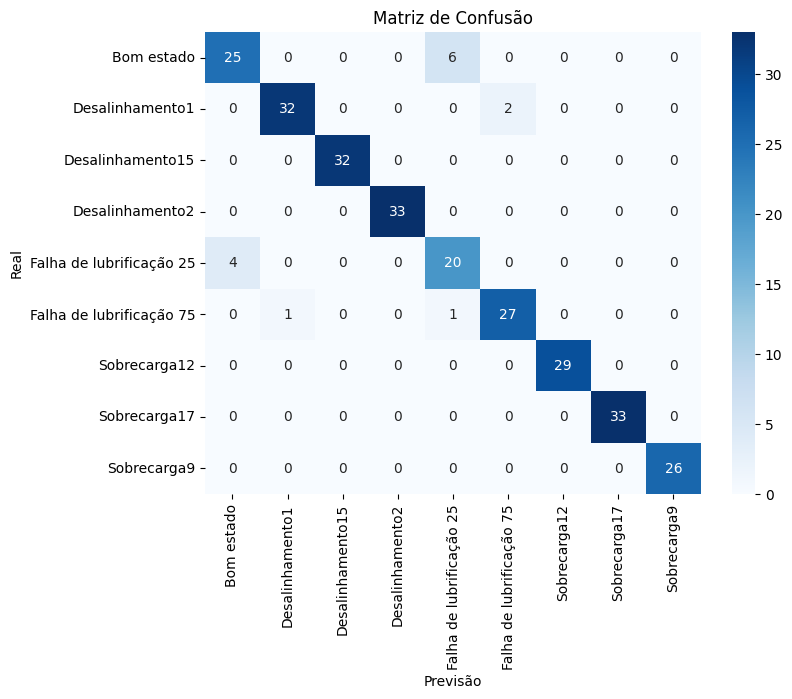

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

Para abrir o repositorio remoto do projeto no GitHub [Clique aqui](https://github.com/WellysonP/Projeto_IA) 
